<a href="https://colab.research.google.com/github/octet07/stock-price-prediction-app/blob/main/stock_price_trend_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Price Trend Prediction with LSTM

import and setups

In [2]:
!pip install yfinance pandas numpy matplotlib scikit-learn keras tensorflow ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=29b90f3d5dc67613809517cb700dcb9f9a4e6bd6e7af126f50fd12748fdb9803
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from ta.momentum import RSIIndicator


fetching stock data

/tmp/ipython-input-4-1080140701.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


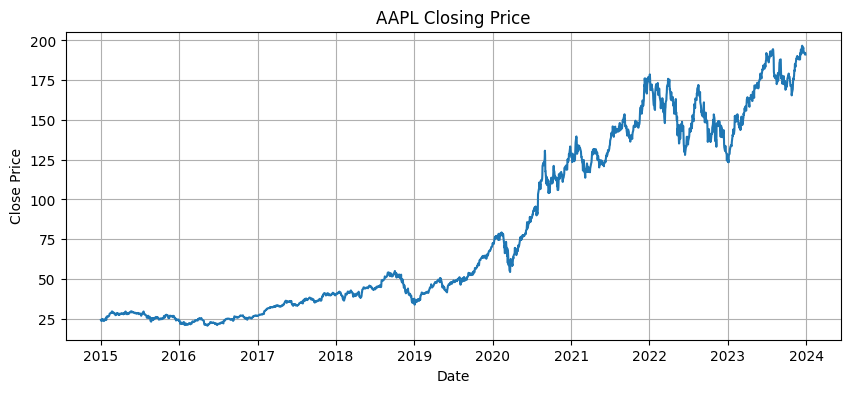

In [4]:
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2023-12-31")

# Just plot to visualize
plt.figure(figsize=(10,4))
plt.plot(df['Close'])
plt.title(f'{ticker} Closing Price')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()


normalising and fetching data for LSTM

In [5]:
# Use only 'Close' price for now
data = df[['Close']].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


splitting data into test and train sets

In [6]:
# 80% for training
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


building LSTM model

In [7]:
from keras import Input

model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  # Recommended input layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


training

In [8]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0323 - val_loss: 0.0022
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 9.4

In [9]:
model.save("lstm_stock_model.keras")


In [20]:
import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']

In [24]:
from google.colab import files
files.download("lstm_stock_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import tensorflow as tf
print(tf.__version__)


2.18.0


 Plot: Training vs Validation Loss

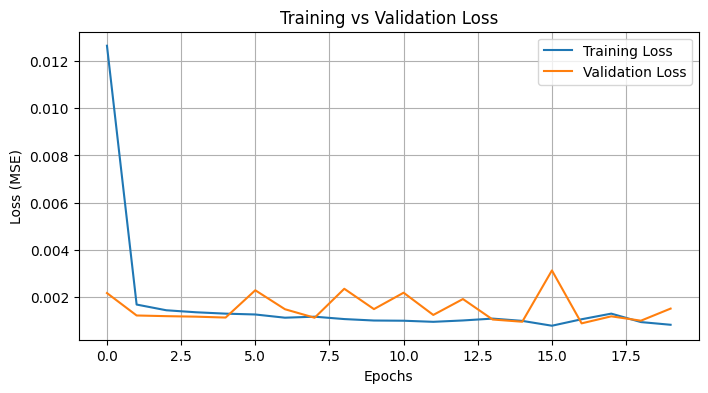

In [10]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


plot predictions v actual


In [11]:
predicted_prices = model.predict(X_test)

# Invert scaling (bring back to original price range)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


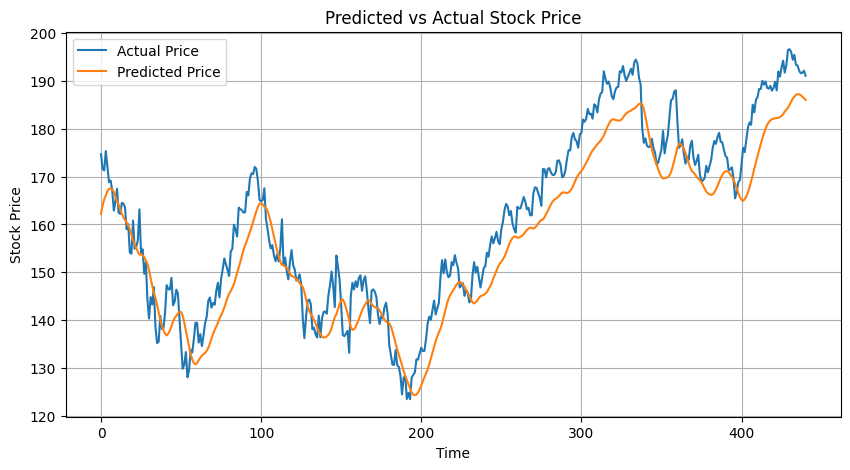

In [12]:
plt.figure(figsize=(10,5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Predicted vs Actual Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


Adding technical indicators

adding moving average

In [13]:
df['MA_20'] = df['Close'].rolling(window=20).mean()


adding RSI

In [14]:
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd

# Convert to numpy array and then back to a Series to ensure 1D structure
close_series = pd.Series(df['Close'].values.flatten(), index=df.index)

rsi = RSIIndicator(close=close_series, window=14)
df['RSI'] = rsi.rsi()

closing price


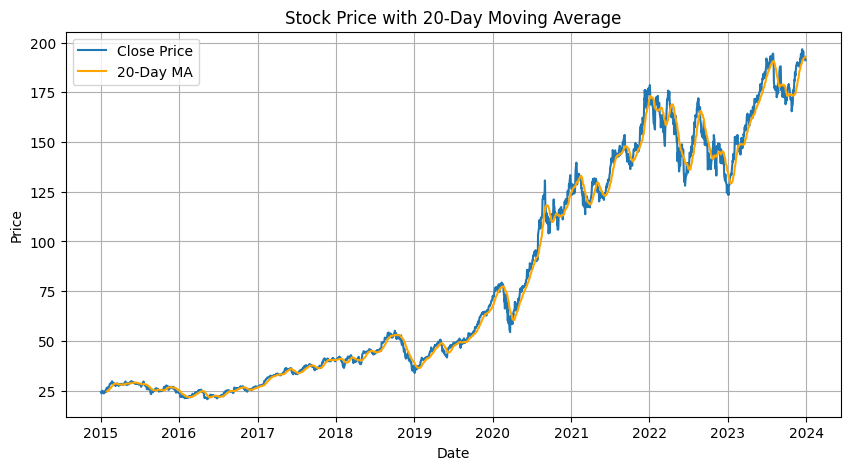

In [15]:
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_20'], label='20-Day MA', color='orange')
plt.title("Stock Price with 20-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


plotting rsi

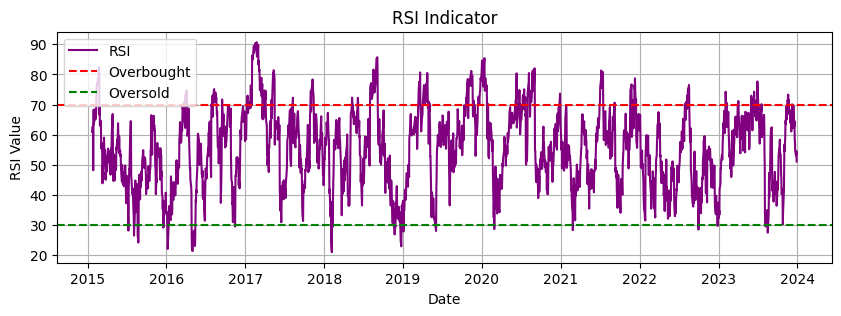

In [16]:
plt.figure(figsize=(10,3))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title("RSI Indicator")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.grid(True)
plt.show()


stream lit dashboard

In [17]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [18]:
with open("dashboard.py", "w") as f:
    f.write("""
import streamlit as st
import yfinance as yf
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator

st.set_page_config(layout="wide")

# Sidebar
st.sidebar.title("Stock Dashboard")
ticker = st.sidebar.text_input("Enter Stock Ticker", value='AAPL')

# Fetch data
df = yf.download(ticker, start="2015-01-01", end="2023-12-31")
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['RSI'] = RSIIndicator(close=df['Close']).rsi()

st.title(f"{ticker} Stock Dashboard")

# Price + MA plot
st.subheader("Closing Price with 20-Day Moving Average")
fig1, ax1 = plt.subplots()
ax1.plot(df['Close'], label="Close")
ax1.plot(df['MA_20'], label="20-Day MA", color='orange')
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.legend()
st.pyplot(fig1)

# RSI plot
st.subheader("RSI (Relative Strength Index)")
fig2, ax2 = plt.subplots()
ax2.plot(df['RSI'], label="RSI", color='purple')
ax2.axhline(70, linestyle='--', color='red', label='Overbought')
ax2.axhline(30, linestyle='--', color='green', label='Oversold')
ax2.set_xlabel("Date")
ax2.set_ylabel("RSI")
ax2.legend()
st.pyplot(fig2)
""")


In [19]:
from google.colab import files
files.download("dashboard.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:

model.save("lstm_stock_model.keras", save_format="keras")

# Download it to your local system
from google.colab import files
files.download("lstm_stock_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download stock data
df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
data = df["Close"].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define model (no InputLayer with batch_shape)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train model
model.fit(X, y, epochs=5, batch_size=32)

# Save model in Keras 3.x-compatible format
model.save("lstm_stock_model.keras")


/tmp/ipython-input-29-2113741924.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Epoch 1/5



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0605
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.3740e-04
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.7706e-04
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.7489e-04
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5.0123e-04


In [30]:


# Download it to your local system
from google.colab import files
files.download("lstm_stock_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-31-4281565140.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

Epoch 1/5



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0417
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.6037e-04
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.8500e-04
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.9821e-04
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.5304e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


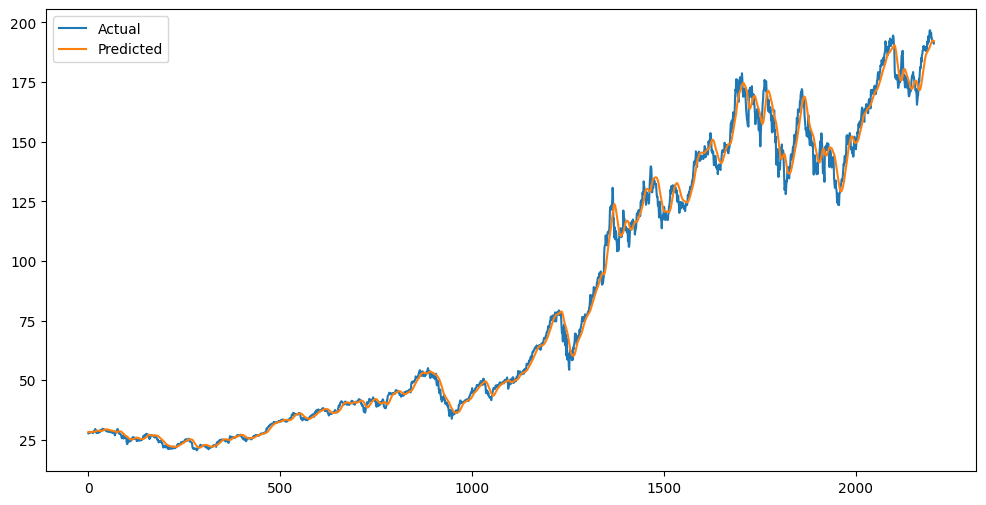

In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 1. Fetch data
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
df = df[['Close']]

# 2. Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 3. Create sequences
X = []
y = []
window = 60

for i in range(window, len(scaled_data)):
    X.append(scaled_data[i-window:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 4. Build model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)

# 5. Predict
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

# 6. Plot
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual")
plt.plot(predicted_prices, label="Predicted")
plt.legend()
plt.show()

# 7. Save model
model.save('lstm_model.h5')


In [32]:
from google.colab import files
files.download('lstm_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
model.save("lstm_model.h5")
from google.colab import files
files.download("lstm_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>